<a href="https://colab.research.google.com/github/Andrey239/ML_LPI_2021/blob/main/seminar08/MLatFIAN_2021_seminar08_Introduction_to_TF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brief intro to TensorFlow

![tf logo](https://www.tensorflow.org/images/tf_logo_social.png)

TensorFlow (tf) is one of the popular symbolic math libraries. Roughly, you can think of it as (a subset of) `numpy` with *GPU support* and *automatic differentiation* + a set of useful tools to build and train neural nets.

The computations in tf are represented in the form of computation graph - a directed graph whose edges are the *numerical values* (or 'tensors') to make calculations with, and whose vertices are operations on those values. The edge directions indicate the direction of the computation flow, i.e. what tensors are the inputs and what are the outputs to a given operation (vertex).

Prior to the release of version 2.0, the main execution paradigm in tf was the *lazy evaluation*. This is an evaluation strategy that delays the execution of an operation until its result is actually needed. This means that in order to make computations you need to first define the computation graph and then execute it separately. While such an approach is reasonable for most NNs (you define the network architecture only once and then repeatedly feed the data to it) it might seem a little unintuitive. Also, this paradigm makes debugging quite troublesome. 

Starting from version 2.0, the default paradigm in tf is the *eager evaluation*, which runs the operations as soon as you create them. This approach might feel more natural and therefore make the development process smoother. It is still possible to use the lazy execution paradigm though.

Let's start this introduction with an overview of the low-level API.

## Low-level intro

In [41]:
# this line ensures you use the new version of tensorflow:
%tensorflow_version 2.x

import tensorflow as tf

print(tf.__version__)

# tf.debugging.set_log_device_placement(True)
        # uncommenting the previous line will let you peek on what's
        # happening behind the scenes (i.e. what operations are
        # created, which devices they are using, etc.)

2.7.0


### Basic stuff

Firstly, consider the following code in `numpy`:

In [42]:
import numpy as np

x = np.array([1., 2., 3.])
y = np.array([3., 2., 1.])

print('---')
print(x + y)

print('---')
print(x * y)

print('---')
print(x.dot(y))

print('---')
print(x[:,np.newaxis].dot(y[np.newaxis,:]))

---
[4. 4. 4.]
---
[3. 4. 3.]
---
10.0
---
[[3. 2. 1.]
 [6. 4. 2.]
 [9. 6. 3.]]


Here's the equivalent in TensorFlow:

In [43]:
x = tf.convert_to_tensor([1., 2., 3.])
y = tf.convert_to_tensor([3., 2., 1.])

print('---')
print(x + y)

print('---')
print(x * y)

print('---')
print(tf.matmul(x[tf.newaxis,:], y[:,tf.newaxis]))

print('---')
print(tf.matmul(x[:,tf.newaxis], y[tf.newaxis,:]))

---
tf.Tensor([4. 4. 4.], shape=(3,), dtype=float32)
---
tf.Tensor([3. 4. 3.], shape=(3,), dtype=float32)
---
tf.Tensor([[10.]], shape=(1, 1), dtype=float32)
---
tf.Tensor(
[[3. 2. 1.]
 [6. 4. 2.]
 [9. 6. 3.]], shape=(3, 3), dtype=float32)


Like `numpy`, TensorFlow is capable of broadcasting unit dimentions, e.g. below we calculate a difference between two tensors of shapes `(3, 1)` and `(1, 3)` to get the result of shape `(3, 3)`:

In [44]:
z = x[:,tf.newaxis] - y[tf.newaxis,:]
print(z)

tf.Tensor(
[[-2. -1.  0.]
 [-1.  0.  1.]
 [ 0.  1.  2.]], shape=(3, 3), dtype=float32)


Actions like `mean`, `max`, `min`, etc. are implemented with the `reduce_*` opetations, e.g.:

In [45]:
print(tf.reduce_sum(z, axis=0))

tf.Tensor([-3.  0.  3.], shape=(3,), dtype=float32)


In [46]:
# now try printing out the max of z along axis 1
<YOUR CODE>

SyntaxError: ignored

Contrary to `numpy`, you cannot assign to tensors:

In [47]:
try:
  z[1,1] = 3.
except Exception as e:
  print(e)

'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment


Tensors are immutable. If you wish to have a modifiable tensor, then you want to use the `tf.Variable`:

In [48]:
z_var = tf.Variable(z)
print(z_var)
z_var[1,1].assign(3.)
print(z_var)

<tf.Variable 'Variable:0' shape=(3, 3) dtype=float32, numpy=
array([[-2., -1.,  0.],
       [-1.,  0.,  1.],
       [ 0.,  1.,  2.]], dtype=float32)>
<tf.Variable 'Variable:0' shape=(3, 3) dtype=float32, numpy=
array([[-2., -1.,  0.],
       [-1.,  3.,  1.],
       [ 0.,  1.,  2.]], dtype=float32)>


In [49]:
# Exercise:
# 1) create a normal random vector (tensorflow tensor) of size 5
# 2) create a uniform random vector (tensorflow tensor) of size 5
# 3) get a vector (of size 5) of max values between 1) and 2)
<YOUR CODE>

# 4*) What's the probability of 3) picking a value from 2) rather than 1)? (calculate a Monte-Carlo estimate)
<YOUR CODE>

SyntaxError: ignored

-----------

### CPU vs GPU

You can check which device's memory an object is stored in:

In [50]:
x = tf.convert_to_tensor([1., 2., 3.])
y = tf.convert_to_tensor([3., 2., 1.])
z = x[:,tf.newaxis] - y[tf.newaxis,:]

print(x.device)
print(y.device)
print(z.device)

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0


In order to check the available devices you can do:

In [51]:
quote = "'"
for d in tf.config.list_logical_devices():
  print(f"Name: {quote + d.name + quote:20s}\t Type:'{d.device_type}'")

Name: '/device:CPU:0'     	 Type:'CPU'
Name: '/device:GPU:0'     	 Type:'GPU'


You can explicitly set the device you want to use for a tensor/operation using `tf.devcie(...)` in a python `with` statement:

In [52]:
with tf.device('/device:GPU:0'):
  x_gpu = tf.identity(x)
print(x.device)
print(x_gpu.device)

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0


Let's compare the performance of CPU and GPU with calculating a tensor product of two relatively large vectors. First on CPU:

In [53]:
# We'll leave the object creation outside the timimg part
with tf.device('/device:CPU:0'):
  x = tf.convert_to_tensor(np.arange(10000).astype('float'))

In [54]:
%%timeit -r1 -n1
with tf.device('/device:CPU:0'):
  print(tf.reduce_sum(tf.matmul(x[:,tf.newaxis], x[tf.newaxis,:])))

tf.Tensor(2499500025000000.0, shape=(), dtype=float64)
1 loop, best of 1: 385 ms per loop


Now same code on GPU:

In [55]:
with tf.device('/device:GPU:0'):
  x = tf.convert_to_tensor(np.arange(10000).astype('float'))

In [56]:
%%timeit -r1 -n1
with tf.device('/device:GPU:0'):
  print(tf.reduce_sum(tf.matmul(x[:,tf.newaxis], x[tf.newaxis,:])))

tf.Tensor(2499500025000000.0, shape=(), dtype=float64)
1 loop, best of 1: 17.5 ms per loop


Note that TensorFlow is smart enought to place tensors and operations on the most efficient devices automatically. E.g. if we create the object on CPU, but then don't specify the device to run computations on, we'll get the following:

In [57]:
with tf.device('/device:CPU:0'):
  x = tf.convert_to_tensor(np.arange(10000).astype('float'))

In [58]:
%%timeit -r1 -n1
print(tf.reduce_sum(tf.matmul(x[:,tf.newaxis], x[tf.newaxis,:])))

tf.Tensor(2499500025000000.0, shape=(), dtype=float64)
1 loop, best of 1: 18.3 ms per loop


----------

### Automatic differentiation

As mentioned earlier, tf can calculate the derivatives for you. This can be done with a `tf.GradientTape` object. This object records the operations of interest to later compute the gradients for:

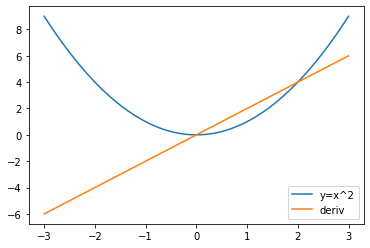

In [59]:
x = tf.convert_to_tensor(np.linspace(-3, 3, 200))

# The operations we need the gradients for should be enclosed
# in a `with` statement with `tf.GradientTape`:
with tf.GradientTape() as t:
  # specify the tensor we'll derive with respect to
  t.watch(x)

  # do the actual operation:
  y = x**2

# get the gradient:
y_prime = t.gradient(y, x)

import matplotlib.pyplot as plt

plt.plot(x, y, label='y=x^2')
plt.plot(x, y_prime, label='deriv')
plt.legend();

You can nest `tf.GradientTape` contexts to calculate higher order derivatives. Can you figure out the right way to code it?

In [60]:
x = tf.convert_to_tensor(np.linspace(-3, 3, 200))

<YOUR CODE>
# y = x**3
# y_prime - first derivative of y wrt x
# y_prime_prime - second derivative of y wrt x

plt.plot(x, y, label='y=x^3')
plt.plot(x, y_prime, label='deriv')
plt.plot(x, y_prime_prime, label='second deriv')
plt.legend();

SyntaxError: ignored

------------

### Example: maximum likelihood fit

Let's generate a Gaussian mixture dataset and then fit its parameters with maximum likelihood.

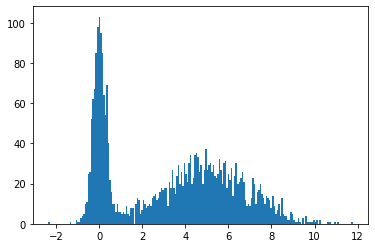

In [61]:
X1 = np.random.normal(size=1000, scale=0.3).astype('float32')
X2 = np.random.normal(size=2000, loc=5., scale=2.).astype('float32')

X = np.concatenate([X1, X2])
np.random.shuffle(X)

plt.hist(X, bins=200);

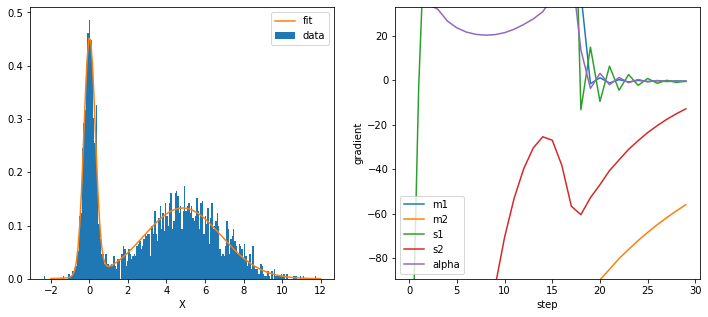

In [62]:
from IPython.display import clear_output
from math import *

# Defining Gaussian PDF using tf functions
def gaussian(x, mu, sigma):
 # <YOUR CODE> # use tf.exp for the exponent, don't forget the normalization
  return 1/tf.sqrt(2*pi*sigma**2)*tf.exp(-(x-mu)**2/(2*sigma**2))
# Arbitrary mixture PDF
def mixture(x, f1, f2, alpha):
  return alpha * f1(x) + (1. - alpha) * f2(x)

# Parameters that we'd like to infer (with an initial guess)
m1    = tf.Variable(1.0)
m2    = tf.Variable(4.0)
s1    = tf.Variable(1.0)
s2    = tf.Variable(1.0)
alpha = tf.Variable(0.5)

# At each gradient update we'll apply this function to
# ensure valid parameter values
def apply_constraints():
#  <YOUR CODE> # ensure the sigmas are positive (greater or equal to some small
              # positive number, e.g. 1e-5) and alpha is in (0, 1) interval
              # hint: use the `assign` method to update the variable values
  if (s1 < 1e-5):
    s1.assign(0.00001)
  if (s2 < 1e-5):
    s2.assign(0.00001)
  if (alpha < 1e-5):
    alpha.assign(0.00001)
  if (alpha > 0.99999):
    alpha.assign(0.99999)
variables = [m1, m2, s1, s2, alpha]

# Defining the overall PDF
def model_pdf(x):
  return mixture(x,
                 lambda t: gaussian(t, m1, s1),
                 lambda t: gaussian(t, m2, s2),
                 alpha)

# Log likelihood
def loglike(x):
  #<YOUR CODE> # hint: the logarithm is in tf.math.log
  return -tf.math.log(model_pdf(x))
learning_rate = 0.0001
grad_history = [] # to keep track of gradient values at different steps

for i in range(30):
  with tf.GradientTape() as t:
    # NOTE: if `variable` was created with `trainable=False`, you need to
    # manually add it to the tape by calling `t.watch(variable)`. By default
    # the variable are created with `trainable=True`

    # Forward pass:
    l = loglike(X)
  
  # Backprop:
  grads = t.gradient(l, variables) # Calculate the gradients
  grad_history.append([g.numpy() for g in grads])

  # Gradient ascent step:
  #step=np.full([len(variables)],0)
  
  for j in range(len(variables)):
    step = variables[j] - learning_rate * grads[j]
    

    variables[j].assign(step)
  apply_constraints()

  ############################
  # Do some plotting
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.hist(X, bins=200, density=True, label='data')
  x_grid = np.linspace(-2, 12, 150)
  plt.plot(x_grid, model_pdf(x_grid), label='fit')
  plt.legend()
  plt.xlabel('X')

  plt.subplot(1, 2, 2)
  lines = plt.plot(np.array(grad_history))
  low = min(grad_history[-1])
  high = max(grad_history[-1])
  plt.ylim(low  - (high - low) * 0.6,
           high + (high - low) * 0.6)
  plt.legend(lines, ['m1', 'm2', 's1', 's2', 'alpha'])
  plt.xlabel('step')
  plt.ylabel('gradient')
  plt.show()
  clear_output(wait=True);

### Example: single hidden layer NN

For this example we'll try to classify some clothes pictures from the Fashion MNIST dataset. We'll use `tensorflow_datasets` to fetch the data.

In [63]:
import tensorflow_datasets as tfds

`tf.data.Dataset` is TensorFlow's abstraction for an arbitrary dataset. It allows building complex loading and processing pipelines by sequentially calling dataset transforming functions.

In the code below `tfds.load(...)` returns a `tf.data.Dataset` object, from which we want to load everything at once (`prefetch(number_of_elements)`) and store it in memory (`cache()`). These transformations will be exectuted once we start iterating through the data.

In [64]:
data_train = tfds.load(name="fashion_mnist", split="train").prefetch(60000).cache()
data_test  = tfds.load(name="fashion_mnist", split="test" ).prefetch(10000).cache()

Let's have a look at the data format:

In [65]:
print(data_train)
print(data_test)

<CacheDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>
<CacheDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>


So we have images of shape 28 by 28 with a single channel and scalar labels.

Now let's just plot some of the training samples.

[['Pullover' 'Trouser' 'Bag' 'Coat' 'Trouser']
 ['Ankle boot' 'Pullover' 'Pullover' 'T-shirt/top' 'Pullover']
 ['Shirt' 'Ankle boot' 'T-shirt/top' 'Sneaker' 'Sandal']
 ['Coat' 'T-shirt/top' 'Trouser' 'Bag' 'T-shirt/top']
 ['Coat' 'Pullover' 'Shirt' 'Sneaker' 'T-shirt/top']]


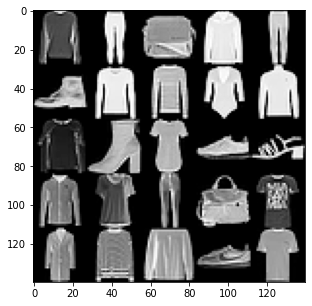

In [66]:
# Array for decoding the categories
label_names = np.array(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle boot'])

# Get a single data batch of 25 images
sample_data = next(iter(data_train.batch(25)))
sample_images = sample_data['image']
sample_labels = sample_data['label']

# Plot the images in a 5x5 grid
plt.figure(figsize=(5, 5))
plt.imshow(
    sample_images.numpy().reshape(5, 5, 28, 28).transpose((0, 2, 1, 3)).reshape(140, 140),
    cmap='gray'
)
# Print corresponding labels
print(label_names[sample_labels.numpy().reshape(5, 5)])

Now that we have some idea about the dataset, we are going to define our model. Since we are working with the low-level API, we are going to define all the calculations explicitly. Therefore, we need to explicitly define all the parameters of our model:

In [67]:
num_hidden = 64

# Weights and biases of our model.
# We'll use He initializtion for weights and zero-initialized biases.
w1 = tf.Variable(
    np.random.normal(size=(28**2, num_hidden)) * np.sqrt(2. / 28**2),
    dtype='float32'
)
b1 = tf.Variable(np.zeros(shape=(num_hidden,)), dtype='float32')

w2 = tf.Variable(
    np.random.normal(size=(num_hidden, 10)) * np.sqrt(2. / num_hidden),
    dtype='float32'
)
b2 = tf.Variable(np.zeros(shape=(10,)), dtype='float32')

variables = [w1, b1, w2, b2]

Now the model itself:

In [68]:
# Main function of our model.
# Given the input images it will return the predicted class probabilites
def model(X):
  # preprocess the data first
  X = tf.reshape((X / 255), (X.shape[0], 28**2))

  # First layer
  activations1 = tf.nn.relu(X @ w1 + b1) # use tf.nn.relu activation

  # Second layer
  probs = tf.nn.softmax(activations1 @ w2 + b2) # use tf.nn.softmax activation
  return probs

# The forward pass: calculate the loss value from a given data batch.
def forward(input_batch):
  # preprocessing
  X = input_batch['image']
  y = input_batch['label']
  y = tf.reshape(y, (y.shape[0], 1))

  probs = model(X)

  # Calculate the loss.
  cross_entropy_loss = -tf.reduce_mean(tf.math.log(tf.gather_nd(probs, y, batch_dims=1)))
    # Hint: tf.gather_nd(probs, y, batch_dims=1) will collect the probabilities of true classes

  return cross_entropy_loss

Now we'll code the main training loop.

Epoch #19, train loss: 0.31949951786994935, test loss: 0.37793269581794736


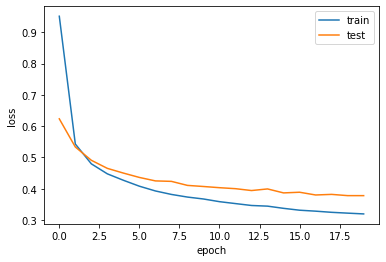

In [69]:
from tqdm import tqdm # a nice tool to track the progress of a loop
import sys

# In earlier examples we updated the variables manually.
# Actually, a set of ready-to-use tools, called optimizers,
# has already been implemented for us.
# Here we'll use the Adam optimizer which is a clever
# modification of simple stochastic gradient descent.
optimizer = tf.optimizers.Adam()
batch_size = 1024

num_epochs = 20

# variables to keep track of the training history
train_losses = []
test_losses = []

# training loop
for i_epoch in range(num_epochs):
  print("Working on epoch #{}".format(i_epoch))
  sys.stdout.flush() # This is to make sure no output is buffered when tqdm is called


  # training part
  epoch_train_loss = 0
  train_samples = 0
  for batch in tqdm(data_train.shuffle(60000).batch(batch_size)):
    with tf.GradientTape() as t:
      loss = forward(batch)
    num_samples = len(batch['label'])
    epoch_train_loss += loss.numpy() * num_samples
    train_samples += num_samples

    grads = t.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
  
  train_losses.append(epoch_train_loss / train_samples)

  # evaluation part
  epoch_test_loss = 0
  test_samples = 0
  for batch in data_test.batch(4096):
    epoch_test_loss += forward(batch).numpy() * len(batch['label'])
    test_samples += len(batch['label'])
  
  test_losses.append(epoch_test_loss / test_samples)

  # printout and plotting part
  clear_output(wait=True)
  print("Epoch #{}, train loss: {}, test loss: {}".format(
      i_epoch, train_losses[-1], test_losses[-1]
  ))
  plt.plot(train_losses, label='train')
  plt.plot(test_losses , label='test')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

Let's check the accuracy of our model.

In [70]:
########################################################
# Extract the data from the dataset into a numpy array
X_batches = []
y_batches = []
for batch in data_test.batch(4096):
  X_batches.append(batch['image'].numpy().astype('float32'))
  y_batches.append(batch['label'].numpy())

X_test = np.concatenate(X_batches)
y_test = np.concatenate(y_batches)

In [71]:
def check_accuracy(model):
  return (model(X_test).numpy().argmax(axis=1) == y_test).mean() # print out the models accuracy on X_test, y_test

In [72]:
check_accuracy(model)

0.8685

Not too bad. Let's have a look at the wrongly classified objects.

True labels:
[['Ankle boot' 'Coat' 'Pullover']
 ['Shirt' 'Pullover' 'Sandal']
 ['Shirt' 'Sandal' 'Coat']]
Predicted labels:
[['Sandal' 'Pullover' 'T-shirt/top']
 ['T-shirt/top' 'Shirt' 'Sneaker']
 ['T-shirt/top' 'Sneaker' 'Dress']]


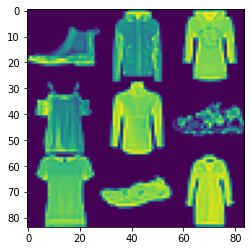

In [73]:
predictions = model(X_test).numpy().argmax(axis=1)
wrong = predictions != y_test
print("True labels:")
print(label_names[y_test[wrong][:9].reshape(3, 3)])
print("Predicted labels:")
print(label_names[predictions[wrong][:9].reshape(3, 3)])

plt.imshow(
  X_test[wrong][:9].reshape(3, 3, 28, 28).transpose(0, 2, 1, 3).reshape(28*3, 28*3)
);

## High-level API (keras)

### Intro

*Quote from https://www.tensorflow.org/guide/keras (see this page for links to mode detailed tutorials):*

> TensorFlow’s high-level APIs are based on the Keras API standard for defining and training neural networks. Keras enables fast prototyping, state-of-the-art research, and production—all with user-friendly APIs.

Simple feed-forward models with single route from input to output can be built with the `tf.keras.Sequential` model:

In [74]:
model = tf.keras.Sequential([
  # First layer will do the preprocessing and reshaping of the data (typically
  # you want to do this step beforehand, outside of the model, in order to
  # improve the performance)
  tf.keras.layers.Lambda(
      lambda x: tf.reshape(x / 255., (-1, 28*28)),
      input_shape=(28, 28, 1), name='preprocessing'
  ),

  # Densely connected hidden layer
  tf.keras.layers.Dense(num_hidden, activation='relu'),

  # Output layer (note there's no activation, not even softmax:
  # this layer will output logits, there are pre-implemented
  # loss functions in `keras` to work with such outputs)
  tf.keras.layers.Dense(10)
])

Once your model is built you can print its summary:

In [75]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Lambda)      (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                50240     
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


Keras models can be easily saved and restored. Here's how to save it to hdf5 format:

In [76]:
model.save('untrained_model.h5', save_format='h5')

Keras models can be used as functions along with the low-level TensorFlow API, such that you can build a fine-tuned training procedure for your needs. However, most of the supervised learning processes fall into the same routine that has been conveniently pre-implemented in `keras`. In order to use it you want to "compile" your model. That is, assign it an optimizer, a loss function and optionally some validation metrics:

In [78]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True))

Once the model is compiled, you can run the training loop using the `fit` method (alternatively, `fit_generator`, see the docs for more info), which can work with different data formats, including tensorflow datasets.

Since our dataset is structured (it has inputs and targets labeled with the 'image' and 'label' keys), we want to convert it to a dataset of tuples `(input, target)`. We'll do that with the `tf.data.Dataset.map` method and the following convertion function:

In [79]:
def unwrap(x):
  return (x['image'], x['label'])

And finally run the training procedure:

In [80]:
model.fit(x=data_train.map(unwrap).shuffle(60000).batch(batch_size),
          epochs=10,
          validation_data=data_test.map(unwrap).batch(4096))

Epoch 1/10
59/59 [==============================] - 1s 8ms/step - loss: 0.9507 - val_loss: 0.6252
Epoch 2/10
59/59 [==============================] - 0s 6ms/step - loss: 0.5455 - val_loss: 0.5427
Epoch 3/10
59/59 [==============================] - 0s 6ms/step - loss: 0.4823 - val_loss: 0.4912
Epoch 4/10
59/59 [==============================] - 0s 6ms/step - loss: 0.4504 - val_loss: 0.4769
Epoch 5/10
59/59 [==============================] - 0s 6ms/step - loss: 0.4290 - val_loss: 0.4486
Epoch 6/10
59/59 [==============================] - 0s 6ms/step - loss: 0.4119 - val_loss: 0.4370
Epoch 7/10
59/59 [==============================] - 0s 6ms/step - loss: 0.3963 - val_loss: 0.4288
Epoch 8/10
59/59 [==============================] - 0s 6ms/step - loss: 0.3858 - val_loss: 0.4188
Epoch 9/10
59/59 [==============================] - 0s 6ms/step - loss: 0.3782 - val_loss: 0.4166
Epoch 10/10
59/59 [==============================] - 0s 6ms/step - loss: 0.3683 - val_loss: 0.4117


Let's save the trained model:

In [81]:
model.save('trained_model.h5', save_format='h5')

We can now check the accuracy of the model. Let's compare it before and after the training by loading the saved weights:

In [82]:
model.load_weights('untrained_model.h5')
check_accuracy(model)

0.1055

In [83]:
model.load_weights('trained_model.h5')
check_accuracy(model)

0.8533

Note that we were saving not just the weights, but the entire model (with the computation graph). This means we can load the entire model without having to specify it's architecture:

In [84]:
check_accuracy(tf.keras.models.load_model('trained_model.h5'))

0.8533

### Validation metrics and callbacks

Now, let's get back to the untrained state of our model and add some more useful tools to the training process. Earlier we mentined that you can add validation metrics to you model. Here's how its done:

In [85]:
model.load_weights('untrained_model.h5')
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.metrics.SparseCategoricalAccuracy()])

Another useful thing is keras callbacks - these are function objects to be called at specific events (e.g. at end of batch or epoch processing, etc.).

One of such callbacks can automatically save our model:

In [86]:
# This callback will save the model every epoch:
saver1 = tf.keras.callbacks.ModelCheckpoint(filepath='model_epoch_{epoch:02d}.h5',
                                            save_freq='epoch')

# This one will save only the best model based on the validation metric (accuracy):
saver2 = tf.keras.callbacks.ModelCheckpoint(filepath='model_best.h5',
                                            monitor='val_sparse_categorical_accuracy',
                                            save_best_only=True)

# We need to provide these callbacks to the `callbacks` argument of the `fit` method:
model.fit(x=data_train.map(unwrap).shuffle(60000).batch(batch_size),
          epochs=30,
          validation_data=data_test.map(unwrap).batch(4096),
          callbacks=[saver1, saver2])

Epoch 1/30
59/59 [==============================] - 2s 22ms/step - loss: 0.9567 - sparse_categorical_accuracy: 0.6938 - val_loss: 0.6336 - val_sparse_categorical_accuracy: 0.7842
Epoch 2/30
59/59 [==============================] - 0s 7ms/step - loss: 0.5514 - sparse_categorical_accuracy: 0.8158 - val_loss: 0.5489 - val_sparse_categorical_accuracy: 0.8088
Epoch 3/30
59/59 [==============================] - 0s 7ms/step - loss: 0.4879 - sparse_categorical_accuracy: 0.8342 - val_loss: 0.4941 - val_sparse_categorical_accuracy: 0.8303
Epoch 4/30
59/59 [==============================] - 1s 8ms/step - loss: 0.4523 - sparse_categorical_accuracy: 0.8453 - val_loss: 0.4741 - val_sparse_categorical_accuracy: 0.8339
Epoch 5/30
59/59 [==============================] - 1s 7ms/step - loss: 0.4312 - sparse_categorical_accuracy: 0.8525 - val_loss: 0.4505 - val_sparse_categorical_accuracy: 0.8415
Epoch 6/30
59/59 [==============================] - 0s 7ms/step - loss: 0.4100 - sparse_categorical_accuracy:

In [87]:
loaded_model = tf.keras.models.load_model('model_best.h5')
predictions = loaded_model(X_test).numpy().argmax(axis=1)
print("Test accuracy is:", (predictions == y_test).mean())

Test accuracy is: 0.8745


### Training history

After the `fit` method was called, a history object is attached to the model. This can be used to check how various metrics behaved during the training process:

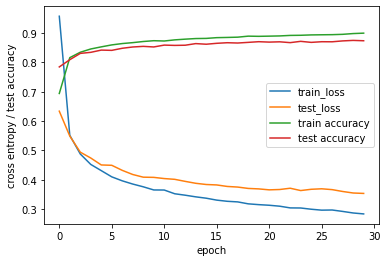

In [88]:
plt.plot(model.history.history['loss']    , label='train_loss')
plt.plot(model.history.history['val_loss'], label='test_loss')

plt.plot(model.history.history['sparse_categorical_accuracy'    ], label='train accuracy')
plt.plot(model.history.history['val_sparse_categorical_accuracy'], label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('cross entropy / test accuracy')
plt.legend();

## Miscellaneous: hidden layer activations / ideal ankle boot

Now let's have a look at what features are being extracted by the hidden layer of the best model.

In [89]:
model = tf.keras.models.load_model('model_best.h5')

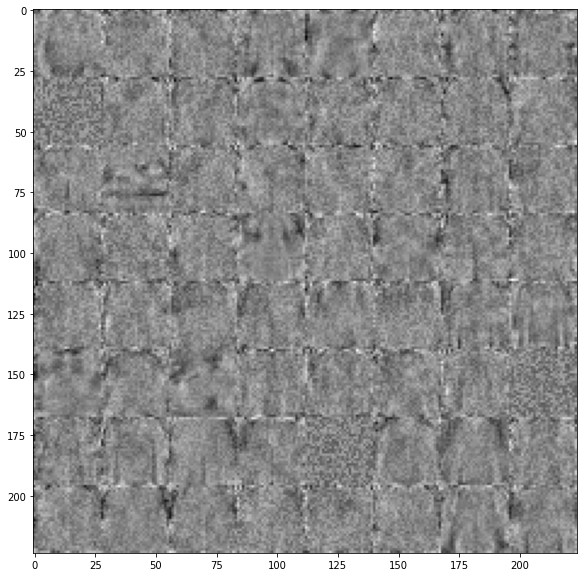

In [90]:
plt.figure(figsize=(10, 10))
hidden_weights = model.layers[1].weights[0].numpy()
hidden_weights /= (hidden_weights**2).sum(axis=0)**0.5

plt.imshow(hidden_weights.T.reshape(8, 8, 28, 28).transpose(0, 2, 1, 3).reshape(28*8, 28*8), cmap='gray');

Here we create a random image and then optimize it to maximize the prediction for a given category:

In [91]:
import time

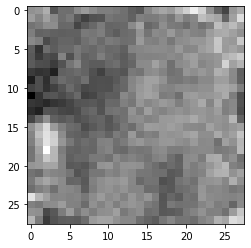

In [92]:
img = tf.Variable(np.random.normal(size=(1, 28*28)), dtype='float32')
category = 9

# Category legend:
# 0 - 'T-shirt/top',
# 1 - 'Trouser',
# 2 - 'Pullover',
# 3 - 'Dress',
# 4 - 'Coat',
# 5 - 'Sandal',
# 6 - 'Shirt',
# 7 - 'Sneaker',
# 8 - 'Bag',
# 9 - 'Ankle boot'

for i in range(1000):
  with tf.GradientTape() as t:
    predictions = model.layers[2](model.layers[1](img))
    score = tf.reduce_min(predictions[:,category:category+1] - 
                          tf.concat([predictions[:,:category],
                                     predictions[:,category+1:]], axis=1),
                          axis=1)

  grads = t.gradient(score, img)
  img.assign_add(0.01 * grads)
  img.assign(img - tf.reduce_min(img, keepdims=True))
  img.assign(img / tf.reduce_max(img))

  if i % 100 == 0:
    clear_output(wait=True)
    plt.imshow(img.numpy().reshape(28, 28), cmap='gray');
    plt.show();
    time.sleep(0.2)
  

In [93]:
img = (255 * img.numpy())

model(img.reshape(1, 28, 28))

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-2.0962884, -1.9053426, -4.9792323, -9.134693 , -9.708886 ,
        -6.2513156, -2.6551094, -3.9160488, -2.1781259, 19.197388 ]],
      dtype=float32)>

## Exercise

### Ex. 1

Move the preprocessing part out of the model into the dataset pipeline (using the `map` method).

In [95]:
model = tf.keras.Sequential([
  # First layer will do the preprocessing and reshaping of the data (typically
  # you want to do this step beforehand, outside of the model, in order to
  # improve the performance)
 # tf.keras.layers.Lambda(
  #    lambda x: tf.reshape(x / 255., (-1, 28*28)),
  #    input_shape=(28, 28, 1), name='preprocessing'
  #),

  # Densely connected hidden layer
  tf.keras.layers.Dense(num_hidden, activation='relu'),

  # Output layer (note there's no activation, not even softmax:
  # this layer will output logits, there are pre-implemented
  # loss functions in `keras` to work with such outputs)
  tf.keras.layers.Dense(10)
])
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics = 'accuracy')

def preprocessing(x):
  prpr = tf.reshape(tf.cast(x['image'], 'float32')/ 255., (-1, 28*28))
  return (prpr, x['label'])

batch_size = 1024
num_epochs=10
model.fit(x=data_train.shuffle(60000).batch(batch_size).map(preprocessing),
          epochs=num_epochs,
          validation_data=data_test.batch(4096).map(preprocessing))

Epoch 1/10
59/59 [==============================] - 2s 20ms/step - loss: 0.9966 - accuracy: 0.6781 - val_loss: 0.6335 - val_accuracy: 0.7868
Epoch 2/10
59/59 [==============================] - 1s 16ms/step - loss: 0.5498 - accuracy: 0.8173 - val_loss: 0.5399 - val_accuracy: 0.8157
Epoch 3/10
59/59 [==============================] - 1s 13ms/step - loss: 0.4850 - accuracy: 0.8360 - val_loss: 0.5034 - val_accuracy: 0.8236
Epoch 4/10
59/59 [==============================] - 1s 15ms/step - loss: 0.4514 - accuracy: 0.8463 - val_loss: 0.4751 - val_accuracy: 0.8370
Epoch 5/10
59/59 [==============================] - 1s 16ms/step - loss: 0.4283 - accuracy: 0.8539 - val_loss: 0.4563 - val_accuracy: 0.8414
Epoch 6/10
59/59 [==============================] - 1s 17ms/step - loss: 0.4117 - accuracy: 0.8584 - val_loss: 0.4410 - val_accuracy: 0.8477
Epoch 7/10
59/59 [==============================] - 1s 13ms/step - loss: 0.3986 - accuracy: 0.8610 - val_loss: 0.4338 - val_accuracy: 0.8501
Epoch 8/10
59

### Ex. 2

Train a model with more layers.

In [96]:
num_hidden_2=64
num_hidden_3=128
num_hidden_4=2
# i dont remeber what num_hidden was but i suppose it was 2 in some degree
model = tf.keras.Sequential([
  # First layer will do the preprocessing and reshaping of the data (typically
  # you want to do this step beforehand, outside of the model, in order to
  # improve the performance)
 # tf.keras.layers.Lambda(
  #    lambda x: tf.reshape(x / 255., (-1, 28*28)),
  #    input_shape=(28, 28, 1), name='preprocessing'
  #),

  # Densely connected hidden layer
  tf.keras.layers.Dense(num_hidden, activation='relu'),
  tf.keras.layers.Dense(num_hidden_2, activation='relu'),
  tf.keras.layers.Dense(num_hidden_3, activation='relu'),
  tf.keras.layers.Dense(num_hidden_4, activation='relu'),
  # Output layer (note there's no activation, not even softmax:
  # this layer will output logits, there are pre-implemented
  # loss functions in `keras` to work with such outputs)
  tf.keras.layers.Dense(10)
])
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics = 'accuracy')

def preprocessing(x):
  prpr = tf.reshape(tf.cast(x['image'], 'float32')/ 255., (-1, 28*28))
  return (prpr, x['label'])

batch_size = 1024
num_epochs=10
model.fit(x=data_train.shuffle(60000).batch(batch_size).map(preprocessing),
          epochs=num_epochs,
          validation_data=data_test.batch(4096).map(preprocessing))

Epoch 1/10
59/59 [==============================] - 1s 13ms/step - loss: 1.9950 - accuracy: 0.2631 - val_loss: 1.7805 - val_accuracy: 0.3134
Epoch 2/10
59/59 [==============================] - 1s 11ms/step - loss: 1.6773 - accuracy: 0.3225 - val_loss: 1.6076 - val_accuracy: 0.3131
Epoch 3/10
59/59 [==============================] - 1s 11ms/step - loss: 1.5216 - accuracy: 0.4512 - val_loss: 1.4557 - val_accuracy: 0.4827
Epoch 4/10
59/59 [==============================] - 1s 11ms/step - loss: 1.3757 - accuracy: 0.5058 - val_loss: 1.3466 - val_accuracy: 0.5367
Epoch 5/10
59/59 [==============================] - 1s 11ms/step - loss: 1.2904 - accuracy: 0.5444 - val_loss: 1.3005 - val_accuracy: 0.5620
Epoch 6/10
59/59 [==============================] - 1s 11ms/step - loss: 1.2239 - accuracy: 0.5660 - val_loss: 1.2297 - val_accuracy: 0.5831
Epoch 7/10
59/59 [==============================] - 1s 10ms/step - loss: 1.1626 - accuracy: 0.5809 - val_loss: 1.1838 - val_accuracy: 0.5821
Epoch 8/10
59

### Ex. 3*

Train a model which is an average of two models with different numbers of layers.
You can:
 - either use low-level API for that (still using `tf.keras.Sequential` models as building blocks)
 - or use `tf.keras.Model` for an arbitrary model (see the very first example from https://www.tensorflow.org/api_docs/python/tf/keras/Model)